# CFL Code Demo 

This example runs a basic CFL experiment on Visual Bars Data 


In [1]:
import numpy as np

## Loading Data 

### Key Points for Loading Data
1. The data should consist of a data set `X` and a data set `Y` that are aligned (each row in `X` corresponds to the row with the same index in `Y`)
2. 'X' should be the causal data set and 'Y' should be the effect data 
3. For most instances of CFL, `X` and `Y` should be reshaped such that that each one is a 2D array with dimensions (n_samples, n_features). Some instances of CFL require that `X` be a 4-D array.

### Load the Visual Bars Data
To create a visual bars data set, we need to import the file `generate_visual_bars_data.py`. If you are trying to generate the visual bars data from outside of the root directory of the `cfl` reposity, add the `visual_bars` directory path to the PYTHONPATH (same as you did for the `cfl` package) for easy importing. 

See the [visual bars page](https://cfl.readthedocs.io/en/latest/Visual_Bars_data.html) for background on the visual bars data set.

In [3]:
#import the file to generate visual bars data 
import visual_bars.generate_visual_bars_data as vbd

# uncomment this line and use it instead if you have added `visual_bars` to the pythonpath
# import generate_visual_bars_data as vbd

In [29]:
# In order to generate visual bars data, we set the number of images we want to generate (`n_samples`), the size of each image in pixels (`im_shape`), and the intensity of random noise in the image (`noise_lvl`). To have reproducible results, we also will set a random seed. 

# create visual bars data 
n_samples = 5000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)


In [30]:
# We save an array of images to a variable `X` and the array of target behavior to a variable `Y`. Note that `X` and `Y` are aligned - they must have the same number of observations, and the nth image in `X` must correspond to the nth target value in `Y`. 

# retrieve the images and the target 
X = vb_data.getImages()
Y = vb_data.getTarget()

# X and Y have the same number of rows  
print(X.shape)
print(Y.shape)
print(X.shape[0]==Y.shape[0])



(5000, 10, 10)
(5000,)
True


## Shaping the Data 

Before putting our data into CFL, we must reshape `X` and `Y` into the right shapes to be passed through the first step, the conditional density estimator (CDE), of CFL. For further guidelines about shaping your data, see [info about CDEs](https://cfl.readthedocs.io/en/latest/CDEs.html#input-shape-for-cdes). 


For this CDE, we must reshape `X` to be a 4-D array with dimensions (n_samples, im_height, im_width, n_channels) and `Y` to be 2 dimensional, with shape (n_samples, n_features)

In [31]:
#reformat x, y into the right shape for the neural net 

# expand X 
X = np.expand_dims(X, -1) 
print(X.shape) #black and white images have just one channel

# expand Y
Y = np.expand_dims(Y, -1)
print(Y.shape)

(5000, 10, 10, 1)
(5000, 1)


## Setting up the CFL Pipeline 

We will now set up an `Experiment`. The `Experiment` will create a CFL pipeline and automatically save all the parameters, results, and the trained models generated during this experiment.


CFL takes in several sets of parameters, each in dictionary form: 
- `data_info`  
- `CDE_params`   
- `cluster_params`   

For further details on the meaning of these parameters, consult the documentation for the clusterer and the CondExp base class. 

Note that not all of the parameters need to be specified - if they are not specified, default values will be provided.  


In this case, we use a convolutional neural net for the CDE, and K-means for clustering. Consult the documentation for the other available models. Note that we didn't specify some parameters, and so those parameters are given default values (values printed below). 

In [32]:
from cfl.experiment import Experiment
from sklearn.cluster import KMeans

# the parameters should be passed in dictionary form 
data_info = {'X_dims' : X.shape, 
             'Y_dims' : Y.shape, 
             'Y_type' : 'categorical' #options: 'categorical' or 'continuous'
            }
cnn_params = {} # pass in empty parameter dictionaries to use the default parameter values (not allowed for data_info)
cluster_params = {'x_model': KMeans(n_clusters=4), 'y_model': KMeans(n_clusters=2)}

# steps of this CFL pipeline
block_names = ['CondExpCNN', 'Clusterer']
block_params = [cnn_params, cluster_params]

# folder to save results to 
save_path = 'results' 

# create the experiment!
my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, block_names=block_names, block_params=block_params, results_path=save_path)

All results from this run will be saved to results\experiment0001
filters not specified in input, defaulting to [32, 16]
input_shape not specified in input, defaulting to (10, 10, 1)
kernel_size not specified in input, defaulting to [(3, 3), (3, 3)]
pool_size not specified in input, defaulting to [(2, 2), (2, 2)]
padding not specified in input, defaulting to ['same', 'same']
conv_activation not specified in input, defaulting to ['relu', 'relu']
dense_units not specified in input, defaulting to 16
dense_activation not specified in input, defaulting to relu
output_activation not specified in input, defaulting to None
batch_size not specified in input, defaulting to 32
n_epochs not specified in input, defaulting to 20
optimizer not specified in input, defaulting to adam
opt_config not specified in input, defaulting to {}
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True

## Training and Predicting with a CFL object  

We now train the CFL object on our data. 

Training CFL pipeline.
Epoch 1/20
118/118 [==============================] - 1s 5ms/step - loss: 0.1851 - val_loss: 0.1502
Epoch 2/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1426 - val_loss: 0.1477
Epoch 3/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1389 - val_loss: 0.1478
Epoch 4/20
118/118 [==============================] - 0s 3ms/step - loss: 0.1376 - val_loss: 0.1507
Epoch 5/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1368 - val_loss: 0.1463
Epoch 6/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1358 - val_loss: 0.1516
Epoch 7/20
118/118 [==============================] - 0s 3ms/step - loss: 0.1340 - val_loss: 0.1486
Epoch 8/20
118/118 [==============================] - 0s 4ms/step - loss: 0.1326 - val_loss: 0.1488
Epoch 9/20
118/118 [==============================] - 0s 3ms/step - loss: 0.1321 - val_loss: 0.1486
Epoch 10/20
118/118 [==============================] - 0s 4ms/step - loss: 0.

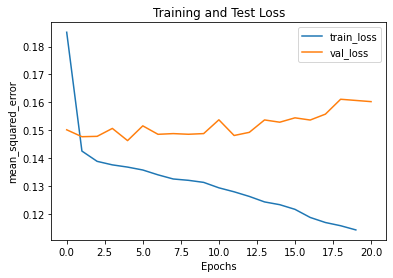

Loading parameters from  tmp_checkpoints/best_weights
Saving parameters to  results\experiment0001\trained_blocks\CondExpCNN


In [33]:
train_results = my_exp.train()

In [34]:
# The results are returned as a dictionary of dictionaries 
# 
# The `x_labels` and `y_labels` are the macrovariable labels for each sample in the `X` and `Y` data set, respectively, 
# Below, we print the first few `x_lbls`. We can see that, there are 4 classes in the data, and that they are represented by the numbers `0` through `3`. Each of these labels tells us the macrovariable to which the corresponding visual bars image was assigned. 

cluster_results = train_results['Clusterer']
print(cluster_results['x_lbls'][:20])

[2 1 0 1 0 0 2 3 0 0 3 1 0 2 0 1 3 1 3 1]


## Predicting on a New Dataset

In [ ]:
# To predict on different data using the same, already trained CFL pipeline, we just create a second data set, and call the predict method on that new dataset: 


In [45]:
n_samples = 100
im_shape = (10, 10)
noise_lvl= 0.03
random_state = 180 

# make second dataset for prediction
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X_new = vb_data.getImages()
Y_new = vb_data.getTarget()

#reformat x, y into the right shape for the neural net 
X_new_CNN = np.expand_dims(X_new, -1) 
Y_new_CNN = np.expand_dims(Y_new, -1)

# put X, Y into a new Dataset object
# add a new dataset to this experiment's known set of data sets 

# register the new dataset with the Experiment
my_exp.add_dataset(X=X_new_CNN, Y=Y_new_CNN, dataset_name='predict_data')  

# predict! 
results_new = my_exp.predict('predict_data')

AssertionError: A Dataset named predict_data has already been added to this Experiment.

In [42]:
# take a look at some of the results for the new data set 
cluster_results_new = results_new['Clusterer']
cluster_results_new['x_lbls'][:20]

array([1, 0, 0, 1, 1, 3, 0, 2, 1, 2, 1, 3, 1, 1, 0, 1, 2, 0, 2, 0])

## Visualize Results 

We can view some images with their predicted label using the `viewImagesandLabels` function. 

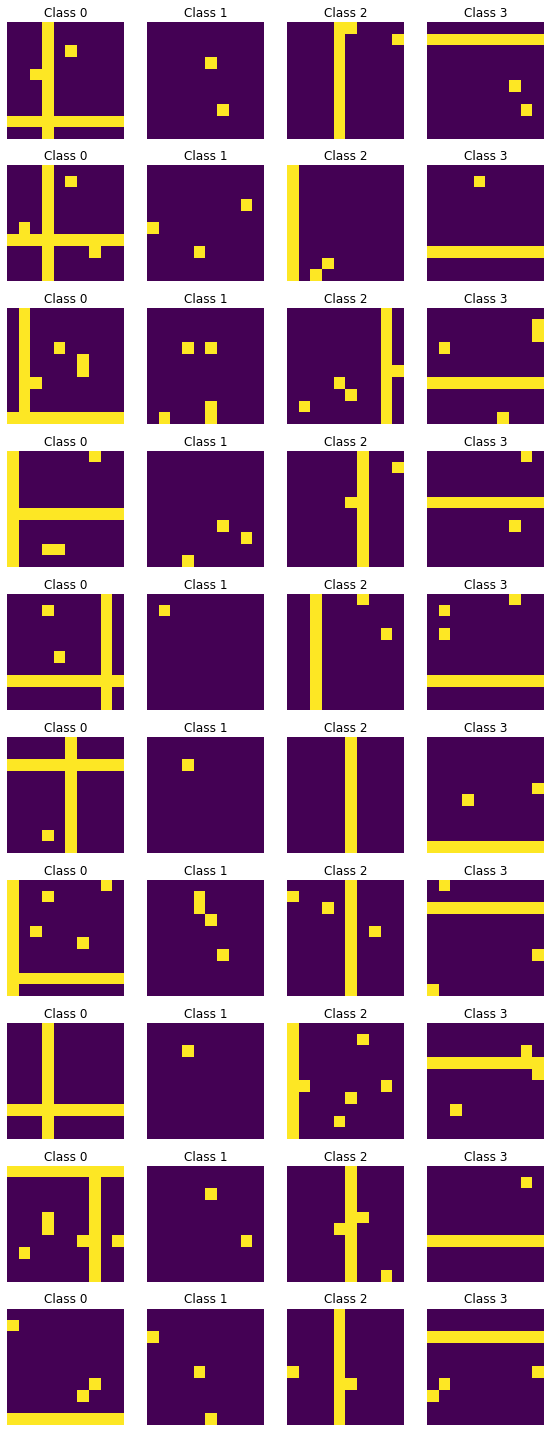

In [46]:
import cfl.visualization_methods.visual_bars_vis as vis

vis.viewImagesAndLabels(X_new, im_shape=im_shape, n_examples=10, x_lbls=cluster_results_new['x_lbls'])

As we can see, CFL has done a pretty good job of recovering the observational partitions (with some errors). For the most part, the images with a horizontal bar, a vertical bar, both, or neither, have been separated into distinct classes. Try this experiment again with a different CDE or a different sample size, and see how your results differ! 